@ 21:54, 4 October, 2022


# XGBoost Hyperparameter Tuning

 <font color=blue> ***The code below is run in Google Colab environment which provides us with GPU for fast calculation.*** </font>


## 01. Objective

The hyperparamter tuning is important not only for improving the performance of the objective function on the training dataset, but also for operating 'regularization' to address "variance-bias trade-off", the risk of 'over-fitting'.  

The objective of this project is to conduct hyperparameter tuning to improve the overall performance of the Native XGBoost API in the context of regression prediction.

This project uses "k-fold cross validation" on the training dataset to tune a set of selected hyperparameters to search for the global minimum of the objective function. After the tuning, we will do a cross-check to compare between the training performance and the test performance of the tuned model. This process is important to assess "variance-bias trade-off".


## 02.  Open Source Native XGBoost API
    This analysis uses the native XGBoost API (not the sklearn API) 
    
    Here is the link to the open source native XGBoost API: https://github.com/dmlc/xgboost 
    
    Here is an excerpt from the XGBoost open source API:
    
> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Kubernetes, Hadoop, SGE, MPI, Dask) and can solve problems beyond billions of examples. (Source: https://github.com/dmlc/xgboost) 

### Advantage to use the Native XGBoost API 
    Apart from the native API, We also have the scikit-learn API of XGBoost. The scikit-learn API is easy to use and fits well in a scikit-learn pipeline.
    Nevertheless, it is sometimes better to use the native version for the following advantages:
    
    * Automatically find the best number of boosting rounds 
    * Built-in cross validation 
    * Custom objective functions



In [ ]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 24.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


Hyperparameter tuning can be computationally very expensive depending on how you set the search grid. Simply because it needs to iterate performance calculations over all the datapoints determined by the search-grid. The more datapoints you have, the more expensive computationally. Very simple. 

Unfortunately, my notebook has a very limited computational capacity. A good news is that Google Colab provides one GPU per user for a free account. And XGBoost has GPU support feature. Altogether, I can speed up the tuning process using Google Colab's GPU.

To check which GPU is allocated by Google Colab

```Python
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
```
Or 
```Python
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi -L
```
For a simple summary


In [ ]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Wed Dec 14 16:16:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |      

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3489100b-28a4-3324-b92e-e9b5248e42c3)


Tesla T4 is allocated to GPU ID =0.


In [ ]:
!pip install -U xgboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import xgboost as xgb # call native XGBoost API # For Google Colab we have a dofferent approach
from sklearn.model_selection import train_test_split # to split the dataset into the train and the test datasets
from sklearn.metrics import mean_squared_error # 
import pandas as pd 
import time # to measure the performance time for some executions such as training and cross validation


In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import squarify #Tree Map creation

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving automobile_prepared.csv to automobile_prepared.csv
Saving DF_OHE_ver2.csv to DF_OHE_ver2.csv


### c) <font color=blue>  Conversion to DMatrices for XGBoost:</font>

Instead of numpy arrays or pandas dataFrame, XGBoost uses DMatrices. So, we have to convert our dataset into DMatrix.

A DMatrix can contain both the features and the target.



> DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data. \
(Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix)



#### <font color=blue> Load data into DMatrix </font>
   Now we convert the numpy arrays of X and y into a DMatrix:


In [ ]:
import pandas as pd

df = pd.read_csv('DF_OHE_ver2.csv')


In [ ]:
df_Original = pd.read_csv('automobile_prepared.csv')

In [ ]:
df.columns.tolist()

['Unnamed: 0',
 'one-hot-encoder__make_alfa-romero',
 'one-hot-encoder__make_audi',
 'one-hot-encoder__make_bmw',
 'one-hot-encoder__make_chevrolet',
 'one-hot-encoder__make_dodge',
 'one-hot-encoder__make_honda',
 'one-hot-encoder__make_isuzu',
 'one-hot-encoder__make_mazda',
 'one-hot-encoder__make_mercedes-benz',
 'one-hot-encoder__make_mercury',
 'one-hot-encoder__make_mitsubishi',
 'one-hot-encoder__make_nissan',
 'one-hot-encoder__make_peugot',
 'one-hot-encoder__make_plymouth',
 'one-hot-encoder__make_porsche',
 'one-hot-encoder__make_renault',
 'one-hot-encoder__make_saab',
 'one-hot-encoder__make_subaru',
 'one-hot-encoder__make_toyota',
 'one-hot-encoder__make_volkswagen',
 'one-hot-encoder__make_volvo',
 'one-hot-encoder__fuel-type_diesel',
 'one-hot-encoder__fuel-type_gas',
 'one-hot-encoder__aspiration_std',
 'one-hot-encoder__aspiration_turbo',
 'one-hot-encoder__body-style_convertible',
 'one-hot-encoder__body-style_hardtop',
 'one-hot-encoder__body-style_hatchback',
 'o

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Entrenamiento
X_train = train.drop(['remainder__lnprice'], axis=1)
y_train = train['remainder__lnprice']
y_train = pd.DataFrame(y_train, columns = ['remainder__lnprice'])

# Testing
X_test = test.drop(['remainder__lnprice'], axis=1)
y_test = test['remainder__lnprice']
y_test = pd.DataFrame(y_test, columns = ['remainder__lnprice'])

In [ ]:
X_train_work = X_train.loc[:, X_train.columns != 'remainder__Key_ID']
X_test_work = X_test.loc[:, X_test.columns != 'remainder__Key_ID']
X_train_work.columns.tolist()

['Unnamed: 0',
 'one-hot-encoder__make_alfa-romero',
 'one-hot-encoder__make_audi',
 'one-hot-encoder__make_bmw',
 'one-hot-encoder__make_chevrolet',
 'one-hot-encoder__make_dodge',
 'one-hot-encoder__make_honda',
 'one-hot-encoder__make_isuzu',
 'one-hot-encoder__make_mazda',
 'one-hot-encoder__make_mercedes-benz',
 'one-hot-encoder__make_mercury',
 'one-hot-encoder__make_mitsubishi',
 'one-hot-encoder__make_nissan',
 'one-hot-encoder__make_peugot',
 'one-hot-encoder__make_plymouth',
 'one-hot-encoder__make_porsche',
 'one-hot-encoder__make_renault',
 'one-hot-encoder__make_saab',
 'one-hot-encoder__make_subaru',
 'one-hot-encoder__make_toyota',
 'one-hot-encoder__make_volkswagen',
 'one-hot-encoder__make_volvo',
 'one-hot-encoder__fuel-type_diesel',
 'one-hot-encoder__fuel-type_gas',
 'one-hot-encoder__aspiration_std',
 'one-hot-encoder__aspiration_turbo',
 'one-hot-encoder__body-style_convertible',
 'one-hot-encoder__body-style_hardtop',
 'one-hot-encoder__body-style_hatchback',
 'o

In [ ]:
X_train_work.shape


(142, 61)

In [ ]:
y_train.shape

(142, 1)

In [ ]:
y_test.shape

(62, 1)

In [ ]:
X_test_work.shape

(62, 61)

In [ ]:
DM_train = xgb.DMatrix(X_train_work, label=y_train)
DM_test = xgb.DMatrix(X_test_work, label=y_test)

## 05. Methodology

Our objective is to perform hyperparamter tuning of XGBoost model to improve its performance while addressing ***variance-bias trade-off*** to alleviate the risk of overfitting.

For this purpose, we use ***k-fold Cross Validation*** to tune the selected hyperparameters. 

***k-fold Cross Validation*** can be iterated over different values of the hyperparameters to search ***the global minimum*** of the regression performance. 



### a) What is k-fold Cross Validation?
Here is a brief summary of k-fold Cross Validation from Wikipedia. source: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation

> In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used,[16] but in general k remains an unfixed parameter.

Needless to say, the cross validation process only use ***the train dataset***. We do not pass ***the test-dataset*** into the cross validation function: `xgb.cv()`.


#### A Tip for Cross-Validation


Here is a recommendation regarding ***Cross Validation*** by Horace at Stackexchange: \
https://stats.stackexchange.com/questions/436894/should-a-training-set-be-used-for-grid-search-with-cross-validation

> It is recommended to hold out a test set that the model only sees at the end, but not during the parameter tuning and model selection steps.
Grid search with cross-validation is especially useful to performs these steps, this is why the author only uses the train data.

> If you use your whole data for this step, you will have picked a model and a parameter set that work best for the whole data, including the test set. Hence, this is prone to overfitting.

> Usually it is recommended to either:

> - Split your dataset into three folds: <font color=blue>train </font>, <font color=green>validation </font>, and <font color=red> test </font>. Then, perform the model selection and hyperparameter search, each time training on <font color=blue>the train set</font>, and checking the score on <font color=green>the validation set</font>.
> - Split into two folds: <font color=blue>train </font> and <font color=red> test </font>, and then perform cross-validations on <font color=blue>the train set</font> to do the model selection and hyperparameter search. 






### b) Fosus for Tuning: Selection of Hyperparameters
There are so many hyperparameters used for XGBoost: https://xgboost.readthedocs.io/en/latest/parameter.html.

Among many hyperparameters built in the native XGBoost API, this analysis focuses on the following 9 hyperparameters under the given limited computational resource availablity. 



#### 1. One Hyperparameter for Iteration Control:

Both the native training function and the native cross-validation function, respectively **xgb.train()** and **xgb.cv()**, enable the users to control the maximum number of iterations, num_boost_round, using 'early_stopping_round'. These 2 hyperparameters work together to control the iteration of the optimization process.


- ***`num_boost_round`*** (int) sets the maximum number of boosting rounds/iterations for the optimization operation. And it can be tuned by using ***`early_stopping_round`***. Here is its definition in the Native Learning API'sdocument:
> num_boost_round (int) – Number of boosting iterations. (Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv()#xgboost.train)

- ***`early_stopping_round`*** monitors the improvement of the selected evaluation metrics (e.g. `mae`) at each iteration and stops the optimization process when further iterations no longer improve the metrics. Here is its definition in the Native Learning API's document:
>early_stopping_rounds (Optional[int]) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in evals. The method returns the model from the last iteration (not the best one). Use custom callback or model slicing if the best model is desired. If there’s more than one item in evals, the last entry will be used for early stopping. If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping. If early stopping occurs, the model will have two additional fields: `bst.best_score`, `bst.best_iteration`. (Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv()#xgboost.train)


Footnote:

***`num_boost_round`*** is a hyperparameter that is set in the native XGBoost API. Its equivalence of Sklearn API is ***`n_estimators`*** according to the definition of ***`n_estimators`*** in Sklearn API doc:
> n_estimators: int, default=100
> The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. Values must be in the range [1, inf).

(Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
    
The remaining 8 hyperparameters (6 for Tree Boosting and 2 for Regularization) are going to be stored in ***the parameter dictionary*** as described in the section c) below.
    
#### 2. Shrinkage:
First, we can control the learning rate with `eta` to penalyze the learning process.

> - <font color=blue> ***eta***</font>  [default=0.3, alias: learning_rate] (range: [0,1]): Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

#### 3. Hyperparameters to Trees Constraints:
Now, this analysis further selected 3 hyperparameters below to constrain trees.

(Source: https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)


> - <font color=blue> ***max_depth*** </font> [default=6] (range: [0,∞]): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value. 
> - <font color=blue> ***min_child_weight*** </font> [default=1] (range: [0,∞]): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
> - <font color=blue> ***gamma*** </font> [default=0, alias: min_split_loss] (range: [0,∞]): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. 



#### 4. Random Sampling

> - <font color=blue> ***subsample*** </font> [default=1] (range: (0,1]): Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. 
> - <font color=blue> ***colsample_bytree*** </font> [default=1] (range of (0, 1]): All colsample_by* parameters is a family of parameters for subsampling of columns and specifies the fraction of columns to be subsampled. colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

#### 5. Regularization of the Objective Function:
    
In order to further address ***variance-bias trade-off***, the problem of ***overfitting***, we can tune ***L1 and L2 regularization hyperparameters***: `reg_alpha` and `reg_lambda`. 

> <font color=blue> ***alpha*** </font> [default=0, alias: <font color=blue> ***reg_alpha***</font>]: L1 regularization term on weights. Increasing this value will make model more conservative.

> <font color=blue> ***lambda*** </font> [default=1, alias: <font color=blue> ***reg_lambda***</font>]: L2 regularization term on weights. Increasing this value will make model more conservative.


    

### c) Parameter Dictionary
Both `xgb.train()` function and `xgb.cv()` function of the Native API requires major hyperparameters to be stored in the form of dictionary. Call it ***the parameter dictionary***. For the hyperprameter tuning, we can use the parameter dictionary to manipulate hyperparameters' values during the k-fold cross-validation.

Among our selection of hyperparameters, the 8 hyperparameters except ***`num_boost_round`*** and  ***`early_stopping_round`*** need to be stored in ***the parameter dictionary***. 

In addition, we need to specify 4 other hyperparameters in ***the parameter dictionary***:
- `objective`: the objective function
- `eval_metric`: the evaluation metrics 
- `gpu_id`: 0 as specified earlier by Google Colab 
- `tree_method`: `gpu_hist` to select GPU setting

Importantly, these four hyperparameters are fixed and not to be tuned during the tuning. 

For the first two hyperparameters, since our objective is 'regression' prediction, we need to select appropriate objective function and evaluation metric 'regression' analysis.

'gpu_id' is required to make GPU's ID specifications in order to use the GPU facility provided by Google Colab.

The last component `tree_method` is set to `gpu_hist` in order to exploit XGBoost's built-in GPU support.


After all, here is the initialization of our parameter dictionary. The values assigned here are solely for the initialization purpose. These values (except for 'objective' and 'eval_metric') will change during the hyperparameter tuning.
```Python
{'objective': 'reg:squarederror', # fixed and not tuned. pick an objective function for Regression. 
 'max_depth': 6,
 'subsample': 1,
 'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': 'mae', # fixed and not tuned. pick a evaluation metric for Regression.
 'gpu_id': 0, 
 'tree_method': 'gpu_hist' # GPU setting
}

```


In [ ]:
param_dict={'objective': 'reg:squarederror', # fixed. pick an objective function for Regression. 
 'max_depth': 6,
 'subsample': 1,
 'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': 'mae', # fixed. picked a evaluation metric for Regression.
 'gpu_id': 0, 
 'tree_method': 'gpu_hist' # XGBoost's built-in GPU support to use Google Colab's GPU
}

In [ ]:
param_dict

{'objective': 'reg:squarederror',
 'max_depth': 6,
 'subsample': 1,
 'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': 'mae',
 'gpu_id': 0,
 'tree_method': 'gpu_hist'}

Besides those hyperparameters specified in ***pram_dict***, we need to initialize 2 other hyperparamters `num_boost_round` and `early_stopping_rounds` outside of ***pram_dict***.

In [ ]:
num_boost_round = 1000
early_stopping_rounds=10

### d) Pre-Tuning Regression

Use the built-in `train()` function to calculate the evaluation metric, MAE, of the test dataset. \
Here is the doc regarding the hyperparameters of `.train()`: \
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=train()#xgboost.train
- evals: a list of pairs (test_dmatrix, name_of_test). Here we will use our datasets in the form of DMatrix.
> *List of validation sets for which metrics will evaluated during training. Validation metrics will help us track the performance of the model.* (Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=train()#xgboost.train)

- early_stopping_rounds: As aforementioned, it is the number of rounds without improvements after which we should stop, here we set it to 10.

- evals_result: 
> *This dictionary stores the evaluation results of all the items in watchlist.*  
> *Example: with a watchlist containing [(dtest,'eval'), (dtrain,'train')] and a parameter containing ('eval_metric': 'logloss'), the evals_result returns:
> {'train': {'logloss': ['0.48253', '0.35953']},
> 'eval': {'logloss': ['0.480385', '0.357756']}}*

Source: https://stackoverflow.com/questions/58495721/how-do-i-use-model-evals-result-in-xgboost-if-i-am-using-gridsearchcv
> In general you can access the dictionary evals_result directly, as opposed to accessing a method of the model, e.g. xgb_model.evals_result(). Here is another, more detailed reference: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/evals_result.py 



In [ ]:
def bias_variance_performance(params):
    cpu_starting_time = time.process_time() # record the starting time of CPU time
    wt_starting_time =time.time() # record the starting time of the Wall Time 
    
    evals_result = {}
    model = xgb.train(
        params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        evals=[(DM_train, "Train"), (DM_test, "Test")],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    train_error = evals_result["Train"]["mae"]
    test_error = evals_result["Test"]["mae"]
    
    wt_performance_time = time.time() - wt_starting_time # measure the Wall-time base performance time of this particular execution.
    cpu_performance_time = time.process_time() - cpu_starting_time # measure the CPU-time base performance time of this particular execution.
    print("Best MAE before the Tuning: {:.4f} with {} rounds".format(model.best_score, model.best_iteration+1))
    print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
    print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))

    return model, evals_result


In [ ]:
pre_model, pre_evals_result=bias_variance_performance(params=param_dict)

[0]	Train-mae:6.14697	Test-mae:6.11841
[1]	Train-mae:4.31599	Test-mae:4.28743
[2]	Train-mae:3.03045	Test-mae:3.00190
[3]	Train-mae:2.13430	Test-mae:2.10672
[4]	Train-mae:1.50522	Test-mae:1.46333
[5]	Train-mae:1.06298	Test-mae:1.01855
[6]	Train-mae:0.75369	Test-mae:0.71664
[7]	Train-mae:0.53460	Test-mae:0.50610
[8]	Train-mae:0.38258	Test-mae:0.36988
[9]	Train-mae:0.27523	Test-mae:0.28447
[10]	Train-mae:0.20099	Test-mae:0.23165
[11]	Train-mae:0.15159	Test-mae:0.20269
[12]	Train-mae:0.11852	Test-mae:0.18860
[13]	Train-mae:0.09535	Test-mae:0.18723
[14]	Train-mae:0.07678	Test-mae:0.17978
[15]	Train-mae:0.06528	Test-mae:0.17795
[16]	Train-mae:0.05492	Test-mae:0.17394
[17]	Train-mae:0.04924	Test-mae:0.17422
[18]	Train-mae:0.04358	Test-mae:0.17389
[19]	Train-mae:0.03857	Test-mae:0.17265
[20]	Train-mae:0.03536	Test-mae:0.17185
[21]	Train-mae:0.03256	Test-mae:0.17107
[22]	Train-mae:0.03094	Test-mae:0.17140
[23]	Train-mae:0.02904	Test-mae:0.17128
[24]	Train-mae:0.02695	Test-mae:0.17052
[25]	Train

In [ ]:
pre_model

In [ ]:
pre_best_performance = pre_model.best_score


#### Utility Function: Visualizing Train Test Performance History
The next cell defines a visualization utility function to plot the performance curve along the iterations.

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
def epoch_MAE_visual(evals_result, title):
    graph_title = str(title) + "_XGBoost_MAE"
    train_error = evals_result["Train"]["mae"]
    test_error = evals_result["Test"]["mae"]
    fig = plt.style.use("ggplot")

    epochs = len(evals_result["Train"]["mae"])
    x_axis = range(0, epochs)
    fig, ax = pyplot.subplots(figsize=(12,12))
    ax.plot(x_axis, evals_result["Test"]["mae"], label="Test")
    ax.plot(x_axis, evals_result["Train"]["mae"], label="Train")
    ax.legend()

    pyplot.xlabel("epochs")
    pyplot.ylabel("mae")
    pyplot.title(graph_title)
    pyplot.show()

# Download the figure as jpeg file.
    
    file_name = graph_title + ".jpg" 
    return fig.savefig(graph_title), graph_title


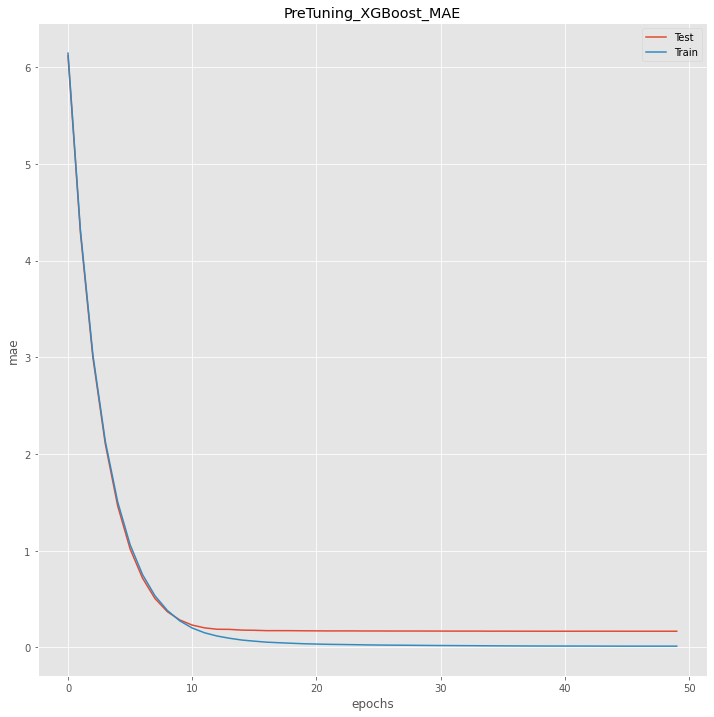

(None, 'PreTuning_XGBoost_MAE')

In [ ]:
epoch_MAE_visual(evals_result=pre_evals_result, title="PreTuning")

### e) Hyperparameter Tuning via k-fold cross-validation: ***cv*** function. 


To tune hyperparameters, we can iterate ***k-fold Cross Validation*** to calculate the performance metrics over all the hyperparameter datapoints on the search-grid: to search ***the global minimum*** of the performance landscape. 


#### Parameters for the Cross Validation function: 
Documentation source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cross%20validation#xgboost.cv


The design of the native cross validation function specifies explicitly a few hyperparameters: such as ***num_boost_round***, ***early_stopping_rounds***, ***nfold***, ***seed***, and ***metrics***. Nevertheless, other hyperparameters, e.g. those constraining trees and those for random sampling, are implicitly included into ***params*** in the dictionary form.    

Importantly, for the cross validation process, we use only "Train Dataset".

- <font color=blue> ***params*** </font>: the hyperparameter dictionary to be defined in the next section. This dictionary sets the scope of the model's hyperparameters tuning.
- <font color=blue> ***dtrain*** </font>: Train Dataset in DMatrix form
- <font color=blue> ***num_boost_round*** </font> (int) – Number of boosting iterations.
- <font color=blue> ***nfold*** </font> (int) – Number of folds in CV.
- <font color=blue> ***metrics*** </font> (string or list of strings) – Evaluation metrics to be watched in CV.
- <font color=blue> ***early_stopping_rounds*** </font> (int) – Activates early stopping. Cross-Validation metric (average of validation metric computed over CV folds) needs to improve at least once in every early_stopping_rounds round(s) to continue training. The last entry in the evaluation history will represent the best iteration. If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping.
- <font color=blue> ***seed*** </font> (int) – Seed used to generate the folds (passed to numpy.random.seed).



Here is the python code.

```python
cv_results = xgb.cv(
        params=param_dict,
        dtrain=DM_train, #only use "Train Dataset" in DMatrix form.
        num_boost_round=num_boost_round,
        seed=42, # seed for randomization
        nfold=5, # k of k-fold cross-validation:an important parameter that determines the ratio of validation dataset
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds   
    )
```




Now, we can customize the cross validation function for the ease of ***pair-wise hyperparameter tuning***. This part is optional based on personal preference. 

The following utility function will calculate the performance metrics for the given set of hyperparamters values.


In [ ]:

def cross_validation(param_dict, DM_train, metrics, num_boost_round, early_stopping_rounds): 
# Exlpanation of parameters passed to the function
# 1) The hyperparamters of the model specification
## params_dict: the parameter dictionary of the model created earlier

# 2) Hyperparameters for iteration control in xgb.train() and xgb.cv()
## num_boost_round: num_boost_round (int) – Number of boosting iterations.
## early_stopping_rounds:Activates early stopping. 
##                       Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. 
# 3) Parameters for the Cross Validation process
## metrics: `mae`
## seed: seed for randomization
## nfold: k of k-fold cross validation
    
    cv_results = xgb.cv(
        params=param_dict,
        dtrain=DM_train, #only use "Train Dataset" in DMatrix. 
        num_boost_round=num_boost_round,
        seed=42, # seed for randomization
        nfold=5, # k of k-fold cross-validation:an important parameter that determines the ratio of validation dataset
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds   
    )
    
    return cv_results

Now, we can define the grid-search process using the pair-wise parameter tuning.

This function, ***pair_wise_gridsearch_CV***, takes three parameters: the names of the pair of hyperparameters to be tuned, ***param1_name*** and ***param2_name***, and the search-grid of the hyperparameter pair, ***gridsearch_params***.

The function iterates the custom cross-validation function, ***cross_validation***, over all the datapoints on the search-grid of the hyperparameter pair defined in ***gridsearch_params*** to search for the global minimum of the performance landscape.


In [ ]:
## Generalization of Pair-wise Gridsearch


def pair_wise_gridsearch_CV(param1_name, param2_name, gridsearch_params):
    
    cpu_starting_time = time.process_time() # record the starting time of CPU time
    wt_starting_time =time.time() # record the starting time of the Wall Time 

    min_mae = float("Inf")
    best_params = None

    x = []
    y = []
    z = []
    for param1, param2 in gridsearch_params:
        # Update our parameter dictionary for the tuning
        param_dict[param1_name] = param1
        param_dict[param2_name] = param2
        print("CV with {}={}, {}={}".format(param1_name, param1,
                             param2_name,
                             param2))
        # calculate cross_validation
        cv_results = cross_validation(param_dict, DM_train, metrics={'mae'}, num_boost_round=1000, early_stopping_rounds=10)
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        
        x.append(param1)
        y.append(param2)
        z.append(mean_mae)
        
        print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
        
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (param1, param2)
     
    wt_performance_time = time.time() - wt_starting_time # measure the Wall-time base performance time of this particular execution.
    cpu_performance_time = time.process_time() - cpu_starting_time # measure the CPU-time base performance time of this particular execution.

    return x, y, z, min_mae, best_params, cpu_performance_time, wt_performance_time
        

### f) Performance Landscape: 3D Visualization of Pair-Wise Hyperparameter Tuning: Tri-Surface Plot with Color Map
- Source1: https://matplotlib.org/3.1.0/tutorials/toolkits/mplot3d.html#sphx-glr-tutorials-toolkits-mplot3d-py
- Source2 Geek4Geeks (Color Map): https://www.geeksforgeeks.org/tri-surface-plot-in-python-using-matplotlib/

We can define a visualization utility function 'Tri-Surface', by using matplotlib’s 'plot_trisurf' to render 3D Visualization of the performance landscape of the hyperparameters. 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Trisurf(xname, yname, x, y, z, min_mae, best_params):
    # (xname, yname): the name of variables to be displayed for visualization
    # (`x`,`y`): all the hyperparamters' datapoints on the search grid 
    # (`z`): the results of the evaluation metric the results of the evaluation metric over the datapoints
    # (`min_mae`, `best_params`): the Native XGBoost API's `k-fold cross-validation` function's outputs the minimum mae result and the corresponding datapoint of the hyperparameters
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection="3d")
    # Creating color map
    my_cmap = plt.get_cmap('RdPu')
    
    # Creating dot plot of the minimum
    ## min_mae*1.01 to float it for the visualization purpose.
    ax.scatter(best_params[0], best_params[1], min_mae, color='red')
    # Tri-Surface Plot
    ax.plot_trisurf(x,y,z,cmap = my_cmap,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel('mae')
    
    # Write the Title
    ax.set_title("Hyperparameters Performance Landscape ("+str(xname) + ' & '+str(yname)+")") 
    
    # Download the figure as jpeg file.
    figname = str(xname) + '_'+str(yname)
    fig.savefig(str(figname) + '.jpg')
    


## 06 The 1st Round of Tuning Implementation

Now, it's time for the implementation of hyperparameter tuning.

We will perform a ***pair-wise hyperparameter tuning*** for each pair at a time using the built-in ***k-fold cross validation*** of the Native XGBoost API. After every pair-wise tuning, we will update the hyperparameter values for each pair with the best result (which yields the lowest value of the valuation metric). In this way, we can incrementally improve the performance of the tuned model. And we move on to the next pair of hyperparameters to repeat the process. 

We will go over this process now. 

### a) The 1st pair: `max_depth` & `eta`

First, we tune the following two hyperparameters together.
> - <font color=blue> ***max_depth*** </font> [default=6] (range: [0,∞]): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value. 
> - <font color=blue> ***eta***</font>  [default=0.3, alias: learning_rate] (range: [0,1]): Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.


In [ ]:
pair_wise_gridsearch_params1 = [
    (max_depth, eta)
    for max_depth in range(5,15)
    for eta in [i/10. for i in range(1, 10)]
]


In [ ]:
 x1, y1, z1, min_mae1, best_params1, cpu_performance_time, wt_performance_time= pair_wise_gridsearch_CV('max_depth', 'eta', pair_wise_gridsearch_params1)

CV with max_depth=5, eta=0.1
	MAE 0.15153204349461444 for 92 rounds
CV with max_depth=5, eta=0.2
	MAE 0.15185458296038248 for 58 rounds
CV with max_depth=5, eta=0.3
	MAE 0.15606158261228664 for 40 rounds
CV with max_depth=5, eta=0.4
	MAE 0.16587322991469808 for 31 rounds
CV with max_depth=5, eta=0.5
	MAE 0.16441768777781518 for 23 rounds
CV with max_depth=5, eta=0.6
	MAE 0.1682479177202497 for 23 rounds
CV with max_depth=5, eta=0.7
	MAE 0.16352946676056962 for 16 rounds
CV with max_depth=5, eta=0.8
	MAE 0.16988376748972928 for 5 rounds
CV with max_depth=5, eta=0.9
	MAE 0.2023001783587075 for 9 rounds
CV with max_depth=6, eta=0.1
	MAE 0.15461861276861483 for 112 rounds
CV with max_depth=6, eta=0.2
	MAE 0.15067751043535804 for 54 rounds
CV with max_depth=6, eta=0.3
	MAE 0.15507144575635787 for 47 rounds
CV with max_depth=6, eta=0.4
	MAE 0.16656045819738227 for 30 rounds
CV with max_depth=6, eta=0.5
	MAE 0.16630618396063743 for 24 rounds
CV with max_depth=6, eta=0.6
	MAE 0.172161242527327

In [ ]:
print("Best params: {}, {}, MAE: {}".format(best_params1[0], best_params1[1], min_mae1))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 13, 0.2, MAE: 0.15005826950073242
Wall-time base performance time: 59.7515 seconds
CPU base performance time: 56.1298 seconds


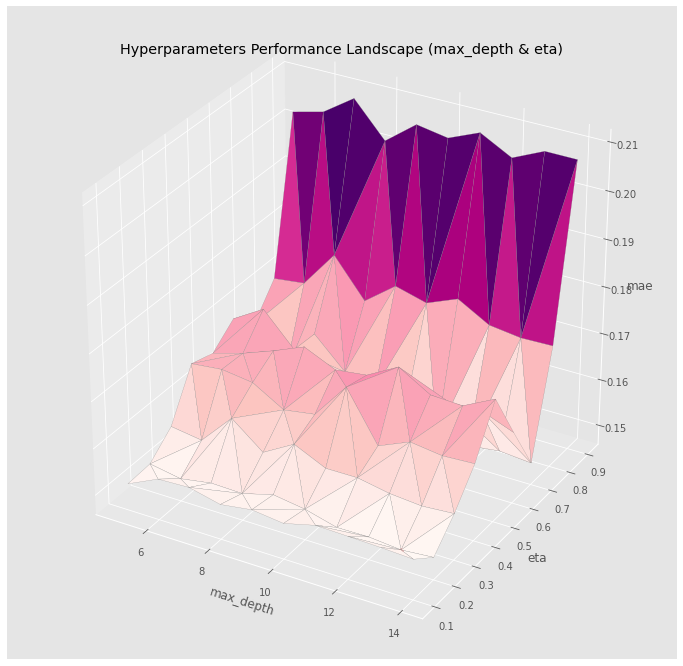

In [ ]:
Trisurf("max_depth", 'eta',x1,y1,z1, min_mae1, best_params1)

In [ ]:
param_dict["max_depth"] = best_params1[0]
param_dict["eta"]= best_params1[1]


### b) The 2nd pair: `subsample` and `colsample_bytree`

Second, we have two hyperparameters associated with random subsampling, `subsample` and `colsample_bytree`. 

Since both deal with random subsampling, they might demonstrate some interactions between each other.
For this reason, we conduct a pair-wise tuning over the two hyperparameters together. 


> - <font color=blue> ***subsample*** </font> [default=1] (range: (0,1]): Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. 

> - <font color=blue> ***colsample_bytree*** </font> [default=1] (range of (0, 1]): All colsample_by* parameters is a family of parameters for subsampling of columns and specifies the fraction of columns to be subsampled. colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.


In [ ]:
pair_wise_gridsearch_params2 = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(1, 10)]
    for colsample_bytree in [i/10. for i in range(1, 10)]
]
# print(gridsearch_params)

In [ ]:
 x2, y2, z2, min_mae2, best_params2 ,cpu_performance_time, wt_performance_time= pair_wise_gridsearch_CV('subsample', 'colsample_bytree', pair_wise_gridsearch_params2)

CV with subsample=0.1, colsample_bytree=0.1
	MAE 0.21031770189407423 for 41 rounds
CV with subsample=0.1, colsample_bytree=0.2
	MAE 0.21057758519214947 for 53 rounds
CV with subsample=0.1, colsample_bytree=0.3
	MAE 0.21629227840254464 for 35 rounds
CV with subsample=0.1, colsample_bytree=0.4
	MAE 0.20778261405493828 for 43 rounds
CV with subsample=0.1, colsample_bytree=0.5
	MAE 0.19500071826239523 for 33 rounds
CV with subsample=0.1, colsample_bytree=0.6
	MAE 0.1869830998293872 for 62 rounds
CV with subsample=0.1, colsample_bytree=0.7
	MAE 0.17634777623444356 for 74 rounds
CV with subsample=0.1, colsample_bytree=0.8
	MAE 0.1938269063169733 for 48 rounds
CV with subsample=0.1, colsample_bytree=0.9
	MAE 0.18166312936491566 for 83 rounds
CV with subsample=0.2, colsample_bytree=0.1
	MAE 0.1755594258237942 for 83 rounds
CV with subsample=0.2, colsample_bytree=0.2
	MAE 0.1937807193530604 for 48 rounds
CV with subsample=0.2, colsample_bytree=0.3
	MAE 0.1890354525279529 for 45 rounds
CV with s

In [ ]:
print("Best params: {}, {}, MAE: {}".format(best_params2[0], best_params2[1], min_mae2))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 0.7, 0.9, MAE: 0.1478233706187732
Wall-time base performance time: 70.4823 seconds
CPU base performance time: 70.6875 seconds


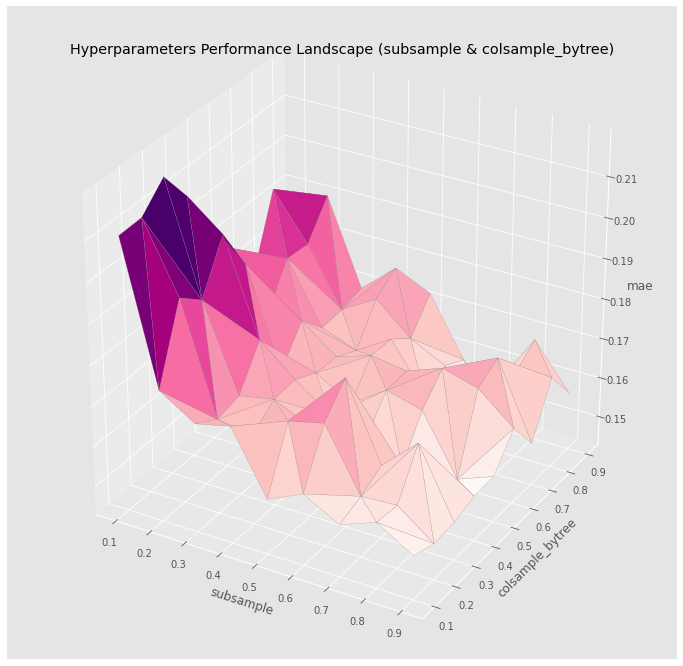

In [ ]:
Trisurf('subsample','colsample_bytree', x2,y2,z2, min_mae2, best_params2)

In [ ]:
param_dict["subsample"] = best_params2[0]
param_dict["colsample_bytree"]= best_params2[1]



### c) The 3rd pair: `min_child_weight` & `gamma`

Third, we tune together the following two hyperparameters associated with partitoin of trees.
> - <font color=blue> ***min_child_weight*** </font> [default=1] (range: [0,∞]): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
> - <font color=blue> ***gamma*** </font> [default=0, alias: min_split_loss] (range: [0,∞]): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. 


In [ ]:
pair_wise_gridsearch_params3 = [
    (min_child_weight, gamma)
    for min_child_weight in range(0, 10)
    for gamma in range(0, 10)
]
# print(gridsearch_params)

In [ ]:
 x3, y3, z3, min_mae3, best_params3, cpu_performance_time, wt_performance_time = pair_wise_gridsearch_CV('min_child_weight', 'gamma', pair_wise_gridsearch_params3)

CV with min_child_weight=0, gamma=0
	MAE 0.1478233706187732 for 68 rounds
CV with min_child_weight=0, gamma=1
	MAE 0.19747850014071158 for 81 rounds
CV with min_child_weight=0, gamma=2
	MAE 0.22064132173660353 for 35 rounds
CV with min_child_weight=0, gamma=3
	MAE 0.23170543210259797 for 58 rounds
CV with min_child_weight=0, gamma=4
	MAE 0.2479882538612253 for 25 rounds
CV with min_child_weight=0, gamma=5
	MAE 0.27383553758630613 for 31 rounds
CV with min_child_weight=0, gamma=6
	MAE 0.29210639328792176 for 24 rounds
CV with min_child_weight=0, gamma=7
	MAE 0.2966158263201784 for 58 rounds
CV with min_child_weight=0, gamma=8
	MAE 0.3211423333642518 for 27 rounds
CV with min_child_weight=0, gamma=9
	MAE 0.3455022701488927 for 24 rounds
CV with min_child_weight=1, gamma=0
	MAE 0.1478233706187732 for 68 rounds
CV with min_child_weight=1, gamma=1
	MAE 0.19747850014071158 for 81 rounds
CV with min_child_weight=1, gamma=2
	MAE 0.22064132173660353 for 35 rounds
CV with min_child_weight=1, gam

In [ ]:
print("Best params: {}, {}, MAE: {}".format(best_params3[0], best_params3[1], min_mae3))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


In [ ]:
Trisurf("min_child_weight", "gamma", x3, y3, z3, min_mae3, best_params3)

In [ ]:
param_dict["min_child_weight"] = best_params3[0]
param_dict["gamma"]= best_params3[1]

The performance landscape of these two partition-associated hyperparameters, `min_child_weight` and `gamma`, did not demonstrat multiple dips and bumps. The relative consistency of in the shape of the performance landscape appears to indicate a model stability within the vicinity of the best values of these two hyperparameters.

### d) The 4th pair: `reg_alpha` and `reg_lambda`

At last, we will conduct the following pair-wise hyperparameter tuning over the following two ***regularization hyperparameters***.


> lambda [default=1, alias: reg_lambda]: L2 regularization term on weights. Increasing this value will make model more conservative.

> alpha [default=0, alias: reg_alpha]: L1 regularization term on weights. Increasing this value will make model more conservative.



In [ ]:
pair_wise_gridsearch_params4 = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
    for reg_lambda in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
]
# print(gridsearch_params)

In [ ]:
 x4, y4, z4, min_mae4, best_params4, cpu_performance_time, wt_performance_time = pair_wise_gridsearch_CV('reg_alpha', 'reg_lambda', pair_wise_gridsearch_params4)

CV with reg_alpha=0, reg_lambda=0
	MAE 0.15078127912699882 for 31 rounds
CV with reg_alpha=0, reg_lambda=0.01
	MAE 0.1468507047944468 for 113 rounds
CV with reg_alpha=0, reg_lambda=0.1
	MAE 0.15848064986355787 for 52 rounds
CV with reg_alpha=0, reg_lambda=1
	MAE 0.15279258154883174 for 44 rounds
CV with reg_alpha=0, reg_lambda=2
	MAE 0.1608697144268769 for 64 rounds
CV with reg_alpha=0, reg_lambda=3
	MAE 0.1649558682747075 for 64 rounds
CV with reg_alpha=0, reg_lambda=4
	MAE 0.15509307889515545 for 103 rounds
CV with reg_alpha=0, reg_lambda=8
	MAE 0.1635483774645575 for 72 rounds
CV with reg_alpha=0, reg_lambda=10
	MAE 0.15910392805860546 for 101 rounds
CV with reg_alpha=0, reg_lambda=12
	MAE 0.1634367199366903 for 140 rounds
CV with reg_alpha=0, reg_lambda=14
	MAE 0.17165335504879503 for 106 rounds
CV with reg_alpha=0.01, reg_lambda=0
	MAE 0.14747371415199315 for 110 rounds
CV with reg_alpha=0.01, reg_lambda=0.01
	MAE 0.1517719794963968 for 67 rounds
CV with reg_alpha=0.01, reg_lambda

In [ ]:
print("Best params: {:.4f}, {:.4f}, MAE: {}".format(best_params4[0], best_params4[1], min_mae4))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 0.0000, 0.0100, MAE: 0.1468507047944468
Wall-time base performance time: 157.6733 seconds
CPU base performance time: 160.2787 seconds


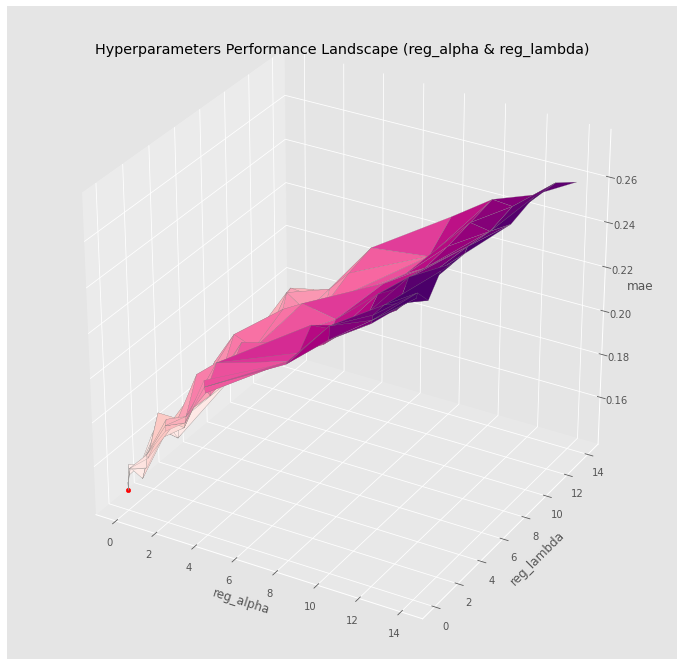

In [ ]:
Trisurf("reg_alpha", "reg_lambda", x4, y4, z4, min_mae4, best_params4)

In [ ]:
param_dict["reg_alpha"] = best_params4[0]
param_dict["reg_lambda"]= best_params4[1]

In [ ]:
print("Parameters after the Pair Wise Tuning:", param_dict)

Parameters after the Pair Wise Tuning: {'objective': 'reg:squarederror', 'max_depth': 13, 'subsample': 0.7, 'eta': 0.2, 'min_child_weight': 0, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.01, 'eval_metric': 'mae', 'gpu_id': 0, 'tree_method': 'gpu_hist'}


### e) Post 1st Pair-Wise Tuning Test Result

In [ ]:
pw_model_1, pw_evals_result_1=bias_variance_performance(param_dict)


[0]	Train-mae:7.00318	Test-mae:6.96961
[1]	Train-mae:5.60618	Test-mae:5.57007
[2]	Train-mae:4.48625	Test-mae:4.44302
[3]	Train-mae:3.59359	Test-mae:3.54640
[4]	Train-mae:2.87775	Test-mae:2.82468
[5]	Train-mae:2.30245	Test-mae:2.24909
[6]	Train-mae:1.84550	Test-mae:1.79433
[7]	Train-mae:1.47551	Test-mae:1.42977
[8]	Train-mae:1.17909	Test-mae:1.14067
[9]	Train-mae:0.94185	Test-mae:0.91256
[10]	Train-mae:0.75480	Test-mae:0.72979
[11]	Train-mae:0.60251	Test-mae:0.58407
[12]	Train-mae:0.48135	Test-mae:0.47341
[13]	Train-mae:0.38668	Test-mae:0.38986
[14]	Train-mae:0.30956	Test-mae:0.31817
[15]	Train-mae:0.24847	Test-mae:0.26685
[16]	Train-mae:0.19972	Test-mae:0.23097
[17]	Train-mae:0.16063	Test-mae:0.20702
[18]	Train-mae:0.12923	Test-mae:0.19152
[19]	Train-mae:0.10307	Test-mae:0.18176
[20]	Train-mae:0.08262	Test-mae:0.17396
[21]	Train-mae:0.06642	Test-mae:0.17036
[22]	Train-mae:0.05361	Test-mae:0.16862
[23]	Train-mae:0.04349	Test-mae:0.16735
[24]	Train-mae:0.03508	Test-mae:0.16688
[25]	Train

In [ ]:
pw_best_performance_1 = pw_model_1.best_score

In [ ]:
print("Best MAE after the Pair-Wise Tuning: {:.4f} with {} rounds".format(
                 pw_model_1.best_score,
                 pw_model_1.best_iteration+1))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))

Best MAE after the Pair-Wise Tuning: 0.1626 with 46 rounds
Wall-time base performance time: 157.6733 seconds
CPU base performance time: 160.2787 seconds


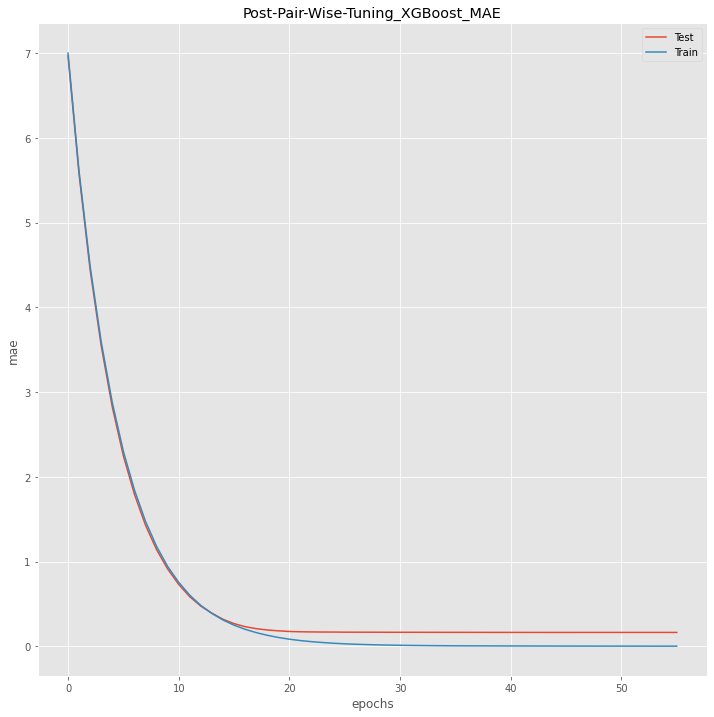

(None, 'Post-Pair-Wise-Tuning_XGBoost_MAE')

In [ ]:
epoch_MAE_visual(evals_result=pw_evals_result_1, title="Post-Pair-Wise-Tuning")

The result yielded a slight improvement in the test performance. 
 

### c) Overall Assessment

Now, let's make a summary table to compare the performance for the cross validation (Test Dataset) and the test for the following three phases.
1. Pre-Tuning Phase
2. Post-1st-Pair-Wise-Tuning Phase
3. Post-2nd-Pair-Wise-Tuning Phase

In [ ]:
data_2 = {"Tuning Phase":["Pre-Tuning", "Post-1st-Pair-Wise-Tuning"], 
          "Tuning (MAE)": ["None", format(min_mae4, '.5f')], 
          'Test Performance (MAE)': [format(pre_best_performance, '.5f'), format(pw_best_performance_1, '.5f')]}
Test_Performance=pd.DataFrame(data_2)
Test_Performance

,Tuning Phase,Tuning (MAE),Test Performance (MAE)
0,Pre-Tuning,None,0.16796
1,Post-1st-Pair-Wise-Tuning,0.14685,0.16258


###   d) Plot the Feature Importance </font>

Based on the hyperparameters tuned in the 1st round tuning, we can plot ***the Feature Importance*** of the tuned model.

Source 1: https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=variable%20importance#xgboost.plot_importance

Source 2: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [ ]:
importance = pw_model_1.get_score(importance_type='weight')
importance

{'Unnamed: 0': 762.0,
 'one-hot-encoder__make_alfa-romero': 6.0,
 'one-hot-encoder__make_audi': 14.0,
 'one-hot-encoder__make_bmw': 11.0,
 'one-hot-encoder__make_chevrolet': 7.0,
 'one-hot-encoder__make_dodge': 12.0,
 'one-hot-encoder__make_honda': 21.0,
 'one-hot-encoder__make_isuzu': 13.0,
 'one-hot-encoder__make_mazda': 14.0,
 'one-hot-encoder__make_mercedes-benz': 9.0,
 'one-hot-encoder__make_mercury': 2.0,
 'one-hot-encoder__make_mitsubishi': 27.0,
 'one-hot-encoder__make_nissan': 13.0,
 'one-hot-encoder__make_peugot': 21.0,
 'one-hot-encoder__make_plymouth': 11.0,
 'one-hot-encoder__make_porsche': 4.0,
 'one-hot-encoder__make_renault': 3.0,
 'one-hot-encoder__make_saab': 18.0,
 'one-hot-encoder__make_subaru': 6.0,
 'one-hot-encoder__make_toyota': 24.0,
 'one-hot-encoder__make_volkswagen': 6.0,
 'one-hot-encoder__make_volvo': 3.0,
 'one-hot-encoder__fuel-type_diesel': 8.0,
 'one-hot-encoder__fuel-type_gas': 1.0,
 'one-hot-encoder__aspiration_std': 25.0,
 'one-hot-encoder__aspirati

In [ ]:
total_importance_value=sum(importance.values())
total_importance_value

2270.0

In [ ]:
sorted_importance =sorted(importance.items(), key=lambda x:x[1], reverse=True)
print(type(sorted_importance))
sorted_importance

<class 'list'>


[('Unnamed: 0', 762.0),
 ('remainder__curb-weight', 248.0),
 ('remainder__length', 116.0),
 ('remainder__wheel-base', 93.0),
 ('remainder__city-mpg', 86.0),
 ('remainder__width', 80.0),
 ('remainder__engine-size', 75.0),
 ('remainder__bore', 70.0),
 ('remainder__horsepower', 70.0),
 ('remainder__peak-rpm', 50.0),
 ('one-hot-encoder__body-style_hatchback', 44.0),
 ('remainder__highway-mpg', 42.0),
 ('one-hot-encoder__body-style_sedan', 39.0),
 ('remainder__num-of-doors', 35.0),
 ('one-hot-encoder__body-style_hardtop', 31.0),
 ('one-hot-encoder__make_mitsubishi', 27.0),
 ('one-hot-encoder__aspiration_std', 25.0),
 ('one-hot-encoder__make_toyota', 24.0),
 ('one-hot-encoder__body-style_wagon', 23.0),
 ('one-hot-encoder__make_honda', 21.0),
 ('one-hot-encoder__make_peugot', 21.0),
 ('one-hot-encoder__fuel-system_2bbl', 20.0),
 ('one-hot-encoder__make_saab', 18.0),
 ('one-hot-encoder__drive-wheels_fwd', 16.0),
 ('one-hot-encoder__fuel-system_mpfi', 15.0),
 ('one-hot-encoder__make_audi', 14.0

In [ ]:
pd.DataFrame.from_dict

<bound method DataFrame.from_dict of <class 'pandas.core.frame.DataFrame'>>

In [ ]:
#Extract Top 5 important features

sorted_importance_top15 = dict(sorted_importance[:15])
type(sorted_importance_top15)

dict

In [ ]:
top15_features=pd.DataFrame.from_dict(sorted_importance_top15, 'index', columns=["Importance"])

In [ ]:
top15_features

,Importance
Unnamed: 0,762.0
remainder__curb-weight,248.0
remainder__length,116.0
remainder__wheel-base,93.0
remainder__city-mpg,86.0
remainder__width,80.0
remainder__engine-size,75.0
remainder__bore,70.0
remainder__horsepower,70.0
remainder__peak-rpm,50.0


In [ ]:
top15_features

,Importance
Unnamed: 0,762.0
remainder__curb-weight,248.0
remainder__length,116.0
remainder__wheel-base,93.0
remainder__city-mpg,86.0
remainder__width,80.0
remainder__engine-size,75.0
remainder__bore,70.0
remainder__horsepower,70.0
remainder__peak-rpm,50.0


In [ ]:
# summarize feature importance
for i,v in enumerate(importance):
 print(i, v)


0 Unnamed: 0
1 one-hot-encoder__make_alfa-romero
2 one-hot-encoder__make_audi
3 one-hot-encoder__make_bmw
4 one-hot-encoder__make_chevrolet
5 one-hot-encoder__make_dodge
6 one-hot-encoder__make_honda
7 one-hot-encoder__make_isuzu
8 one-hot-encoder__make_mazda
9 one-hot-encoder__make_mercedes-benz
10 one-hot-encoder__make_mercury
11 one-hot-encoder__make_mitsubishi
12 one-hot-encoder__make_nissan
13 one-hot-encoder__make_peugot
14 one-hot-encoder__make_plymouth
15 one-hot-encoder__make_porsche
16 one-hot-encoder__make_renault
17 one-hot-encoder__make_saab
18 one-hot-encoder__make_subaru
19 one-hot-encoder__make_toyota
20 one-hot-encoder__make_volkswagen
21 one-hot-encoder__make_volvo
22 one-hot-encoder__fuel-type_diesel
23 one-hot-encoder__fuel-type_gas
24 one-hot-encoder__aspiration_std
25 one-hot-encoder__aspiration_turbo
26 one-hot-encoder__body-style_convertible
27 one-hot-encoder__body-style_hardtop
28 one-hot-encoder__body-style_hatchback
29 one-hot-encoder__body-style_sedan
30 on

In [ ]:
from xgboost import plot_importance

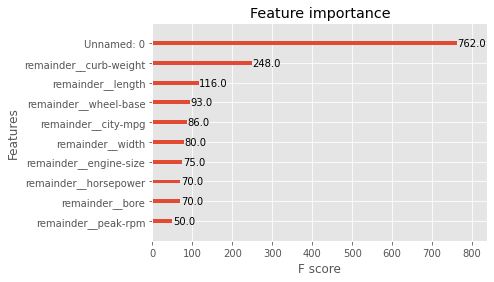

In [ ]:
plot_importance(pw_model_1, max_num_features=10)
pyplot.savefig('plot.png')
pyplot.show()

In [ ]:
pw_model_1.best_iteration

45

In [ ]:
num_boost_round = pw_model_1.best_iteration + 1
best_model = xgb.train(
    param_dict,
    DM_train,
    num_boost_round=num_boost_round,
    evals=[(DM_test, "Test")]
)

[0]	Test-mae:6.96961
[1]	Test-mae:5.57007
[2]	Test-mae:4.44302
[3]	Test-mae:3.54640
[4]	Test-mae:2.82468
[5]	Test-mae:2.24909
[6]	Test-mae:1.79433
[7]	Test-mae:1.42977
[8]	Test-mae:1.14067
[9]	Test-mae:0.91256
[10]	Test-mae:0.72979
[11]	Test-mae:0.58407
[12]	Test-mae:0.47341
[13]	Test-mae:0.38986
[14]	Test-mae:0.31817
[15]	Test-mae:0.26685
[16]	Test-mae:0.23097
[17]	Test-mae:0.20702
[18]	Test-mae:0.19152
[19]	Test-mae:0.18176
[20]	Test-mae:0.17396
[21]	Test-mae:0.17036
[22]	Test-mae:0.16862
[23]	Test-mae:0.16735
[24]	Test-mae:0.16688
[25]	Test-mae:0.16575
[26]	Test-mae:0.16539
[27]	Test-mae:0.16527
[28]	Test-mae:0.16510
[29]	Test-mae:0.16451
[30]	Test-mae:0.16431
[31]	Test-mae:0.16436
[32]	Test-mae:0.16413
[33]	Test-mae:0.16397
[34]	Test-mae:0.16385
[35]	Test-mae:0.16378
[36]	Test-mae:0.16360
[37]	Test-mae:0.16346
[38]	Test-mae:0.16310
[39]	Test-mae:0.16300
[40]	Test-mae:0.16292
[41]	Test-mae:0.16290
[42]	Test-mae:0.16266
[43]	Test-mae:0.16261
[44]	Test-mae:0.16259
[45]	Test-mae:0.1625

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(best_model.predict(DM_test), y_test)

0.1625831001683232

In [ ]:
best_model.save_model("my_model.model")

In [ ]:
bst2 = xgb.Booster(model_file="my_model.model")

preds2 = bst2.predict(DM_test)

In [ ]:
preds2.shape

(62,)

In [ ]:
type(preds2)

numpy.ndarray

In [ ]:
prediction = pd.DataFrame(preds2, columns = ["lnprice"])

In [ ]:
type(prediction)

pandas.core.frame.DataFrame

In [ ]:
prediction.shape

(62, 1)

In [ ]:
prediction.head()

,lnprice
0,8.779658
1,8.878928
2,9.664174
3,9.088256
4,8.738699


In [ ]:
y_test.index

Int64Index([ 15,   9, 115,  78,  66,  45, 132, 161, 201, 181,  69, 163, 167,
            152,  56, 191,  18,  79,  55, 146, 177,  97,  95,  30, 127,  16,
            174,  86, 135, 124,  65,  68, 128,  67,  76, 100, 140, 138, 144,
             84,  82, 199,  93,  38,  24,  96, 111,  29,  19,  60, 155, 168,
             90,   5, 153, 118, 193, 143, 190, 176,  73, 173],
           dtype='int64')

In [ ]:
prediction["Key-ID"]=y_test.index

In [ ]:
prediction

,lnprice,Key-ID
0,8.779658,15
1,8.878928,9
2,9.664174,115
3,9.088256,78
4,8.738699,66
...,...,...
57,8.888569,143
58,9.564714,190
59,9.330016,176
60,9.445163,73


In [ ]:
prediction=prediction.set_index('Key-ID')

In [ ]:
prediction

,lnprice
Key-ID,
15,8.779658
9,8.878928
115,9.664174
78,9.088256
66,8.738699
...,...
143,8.888569
190,9.564714
176,9.330016


In [ ]:
prediction_sorted=prediction.sort_index(ascending=True)

In [ ]:
prediction_sorted

,lnprice
Key-ID,
5,8.967896
9,8.878928
15,8.779658
16,9.642959
18,8.673266
...,...
190,9.564714
191,9.384615
193,9.633511


In [ ]:
print("Type: ",type(y_test))
y_test.shape

Type:  <class 'pandas.core.frame.DataFrame'>


(62, 1)

In [ ]:
y_test_sorted=y_test.sort_index(ascending=True)

In [ ]:
y_test_sorted.rename(columns = {'remainder__lnprice':'lnprice'}, inplace = True)
y_test_sorted

,lnprice
5,8.533460
9,8.916640
15,9.696094
16,8.359837
18,8.509363
...,...
190,9.495143
191,9.535679
193,9.468079
199,9.731809


In [ ]:
type(y_test_sorted)

pandas.core.frame.DataFrame

In [ ]:
y_test_sorted.shape

(62, 1)

In [ ]:
X_test.head(3)

,Unnamed: 0,one-hot-encoder__make_alfa-romero,one-hot-encoder__make_audi,one-hot-encoder__make_bmw,one-hot-encoder__make_chevrolet,one-hot-encoder__make_dodge,one-hot-encoder__make_honda,one-hot-encoder__make_isuzu,one-hot-encoder__make_mazda,one-hot-encoder__make_mercedes-benz,...,remainder__length,remainder__width,remainder__curb-weight,remainder__num-of-cylinders,remainder__engine-size,remainder__bore,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg
15,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854584,-0.762999,0.854793,-1.0,-1.222786,1.982875,1.083377,-1.266342,1.618825,-0.344549
9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.080473,-2.632736,-0.376324,-1.0,-1.040125,1.982875,0.309467,0.921918,1.064491,-0.206609
115,115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.259693,1.059993,1.078449,0.0,1.517115,0.218081,1.636170,0.062956,-1.014262,-0.758369


In [ ]:
X_test.rename(columns={'Unnamed: 0':'Key-ID'}, inplace=True )

In [ ]:
X_test.head(3)

,Key-ID,one-hot-encoder__make_alfa-romero,one-hot-encoder__make_audi,one-hot-encoder__make_bmw,one-hot-encoder__make_chevrolet,one-hot-encoder__make_dodge,one-hot-encoder__make_honda,one-hot-encoder__make_isuzu,one-hot-encoder__make_mazda,one-hot-encoder__make_mercedes-benz,...,remainder__length,remainder__width,remainder__curb-weight,remainder__num-of-cylinders,remainder__engine-size,remainder__bore,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg
15,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854584,-0.762999,0.854793,-1.0,-1.222786,1.982875,1.083377,-1.266342,1.618825,-0.344549
9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.080473,-2.632736,-0.376324,-1.0,-1.040125,1.982875,0.309467,0.921918,1.064491,-0.206609
115,115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.259693,1.059993,1.078449,0.0,1.517115,0.218081,1.636170,0.062956,-1.014262,-0.758369


In [ ]:
X_SORTED=X_test.sort_values(by=['Key-ID'], ascending=True)

In [ ]:
X_SORTED.head(3)

,Key-ID,one-hot-encoder__make_alfa-romero,one-hot-encoder__make_audi,one-hot-encoder__make_bmw,one-hot-encoder__make_chevrolet,one-hot-encoder__make_dodge,one-hot-encoder__make_honda,one-hot-encoder__make_isuzu,one-hot-encoder__make_mazda,one-hot-encoder__make_mercedes-benz,...,remainder__length,remainder__width,remainder__curb-weight,remainder__num-of-cylinders,remainder__engine-size,remainder__bore,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg
5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.542898,-1.230433,-1.250800,0.0,-1.274974,1.982875,-1.487109,-0.457204,-0.044177,-1.172189
9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.080473,-2.632736,-0.376324,-1.0,-1.040125,1.982875,0.309467,0.921918,1.064491,-0.206609
15,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854584,-0.762999,0.854793,-1.0,-1.222786,1.982875,1.083377,-1.266342,1.618825,-0.344549


In [ ]:
Key_list=X_SORTED['Key-ID'].tolist()

In [ ]:
len(Key_list)

62

In [ ]:
# Original Data Frame given by Facundo
O_test_df=df_Original.loc[df_Original['Key_ID'].isin(Key_list)]
#df_Original

In [ ]:
O_test_df.shape

(62, 25)

In [ ]:
O_test_df["Key_ID"].head()

5      5
9      9
15    15
16    16
18    18
Name: Key_ID, dtype: int64

In [ ]:
O_test_df.shape

(62, 25)

In [ ]:
O_Test_X = O_test_df.drop(['lnprice'], axis=1)

In [ ]:
O_Test_X.columns.tolist()

['Key_ID',
 'make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg']

In [ ]:
y_test_sorted.shape

(62, 1)

In [ ]:
import numpy as np

y_test_sorted_USD = np.exp(y_test_sorted)
prediction_sorted_USD = np.exp(prediction_sorted)


In [ ]:
y_test_sorted_USD.shape

(62, 1)

In [ ]:
y_test_sorted_USD

,lnprice
5,5082.000001
9,7454.999999
15,16253.999995
16,4272.000002
18,4960.999999
...,...
190,13295.000004
191,13845.000005
193,12939.999999
199,16845.000003


In [ ]:
prediction_sorted_USD

,lnprice
Key-ID,
5,7847.077148
9,7179.092285
15,6500.655273
16,15412.877930
18,5844.559082
...,...
190,14252.881836
191,11903.822266
193,15267.942383


In [ ]:
type(y_test_sorted)

pandas.core.frame.DataFrame

In [ ]:
O_Test_X = O_Test_X.loc[:, O_Test_X.columns != 'Key_ID'] 

In [ ]:
O_Test_X.shape

(62, 23)

In [ ]:
features = O_Test_X.columns.values.tolist()
categorical_features = O_Test_X.dtypes[O_Test_X.dtypes == 'object'].index.tolist()

In [ ]:
len(features)

23

In [ ]:
len(categorical_features)

10

In [ ]:
features

['make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg']

In [ ]:
O_Test=O_Test_X

In [ ]:
O_Test.head(3)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
5,volkswagen,gas,std,four,convertible,rwd,front,-2.093187,-1.794746,0.639303,...,cuatro-o-menos,1.203984,idi,-1.113255,-0.69856,2.922555,0.115990,3.783796,0.371573,0.345151
9,chevrolet,gas,std,four,hatchback,rwd,front,0.027136,0.698741,0.639303,...,cuatro-o-menos,1.491021,mpfi,1.982875,-0.69856,-0.264212,-0.796118,0.039041,0.648740,-2.413649
15,audi,diesel,std,two,hatchback,fwd,front,0.190238,-1.560982,-1.230433,...,cuatro-o-menos,-0.622617,mpfi,-1.113255,-0.69856,-0.754483,-1.459469,1.719099,1.618825,2.276311


In [ ]:
O_Test_X.shape

(62, 23)

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/selection/code/error_analysis.txt \
    --quiet --no-clobber
!pip install -r error_analysis.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.1/785.1 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.4/92.4 kB 12.6 MB/s eta 0:00:00
 

In [ ]:
from raiwidgets import ErrorAnalysisDashboard
from interpret_community.common.constants import ModelTask

In [ ]:
O_Test_X.shape


In [ ]:
type(categorical_features)
len(categorical_features)

In [ ]:
type(features)
len(features)

In [ ]:
prediction_sorted_USD.shape

In [ ]:
O_Test_X_EA = O_Test_X

In [ ]:
ErrorAnalysisDashboard(dataset=O_Test_X_EA,
                       true_y=y_test_sorted_USD, 
                       categorical_features=categorical_features,
                       features=features, 
                       pred_y=prediction_sorted_USD, 
                       model_task= ModelTask.Regression)

In [ ]:

O_Test["Price"]= y_test_sorted_USD


In [ ]:
O_Test["Prediction"]=prediction_sorted_USD

In [ ]:
min_price = O_Test["Price"].min()
max_price = O_Test["Price"].max()
price_bins = np.linspace(min_price, max_price, 11)
price_labels = list({ i for i in range(0,10)})
O_Test["Price-bins"] = pd.cut(O_Test["Price"], bins=price_bins, labels=price_labels, include_lowest=True)


In [ ]:
min_height = O_Test["height"].min()
max_height = O_Test["height"].max()
height_bins = np.linspace(min_height, max_height, 11)
height_labels = list({ i for i in range(0,10)})
O_Test["Height-bins"] = pd.cut(O_Test["height"], bins=height_bins, labels=height_labels, include_lowest=True)


In [ ]:
price_bins

array([ 4272.00000154,  7350.39999495, 10428.79998836, 13507.19998178,
       16585.59997519, 19663.9999686 , 22742.39996201, 25820.79995543,
       28899.19994884, 31977.59994225, 35055.99993566])

In [ ]:
height_bins

In [ ]:
price_labels

In [ ]:
height_labels

In [ ]:
O_Test["error"]=O_Test["Prediction"] - O_Test["Price"]
O_Test["Squared Error"] = O_Test["error"]**2
O_Test["SE Contribution"] = O_Test["Squared Error"]/O_Test["Squared Error"].sum() 

In [ ]:
O_Test_X.shape

In [ ]:
 O_Test['height']

5      2.760561
9      0.009610
15     0.009610
16     0.795596
18    -0.776376
         ...   
190   -0.540580
191   -0.776376
193   -0.776376
199   -0.029689
201   -0.029689
Name: height, Length: 62, dtype: float64

In [ ]:
O_Test.shape[0]

In [ ]:
O_Test['height_category']=[1 if i > 0.15 else 0 for i in O_Test['height']]
#[x+1 if x >= 45 else x+5 for x in xs]

In [ ]:
O_Test['height_category'].head()

5     1
9     0
15    0
16    1
18    0
Name: height_category, dtype: int64

In [ ]:
# import seaborn library
import seaborn as sns
import squarify

In [ ]:
import plotly.express as px

In [ ]:
grouped_df = O_Test.groupby('make')[['SE Contribution']].sum()
type(grouped_df)


pandas.core.frame.DataFrame

In [ ]:
grouped_df['count'] = O_Test.groupby(['make'])[['make']].count()

In [ ]:
grouped_df.sort_values(by=['SE Contribution'], ascending=False)

,SE Contribution,count
make,,
volvo,0.272980,1
audi,0.212443,2
mazda,0.142293,6
subaru,0.070260,4
toyota,0.063133,9
nissan,0.055924,5
plymouth,0.045290,3
mercedes-benz,0.044685,6
peugot,0.026167,5


,SE Contribution,count
make,,
volvo,0.272980,1
audi,0.212443,2
mazda,0.142293,6
subaru,0.070260,4
toyota,0.063133,9
nissan,0.055924,5
plymouth,0.045290,3
mercedes-benz,0.044685,6
peugot,0.026167,5


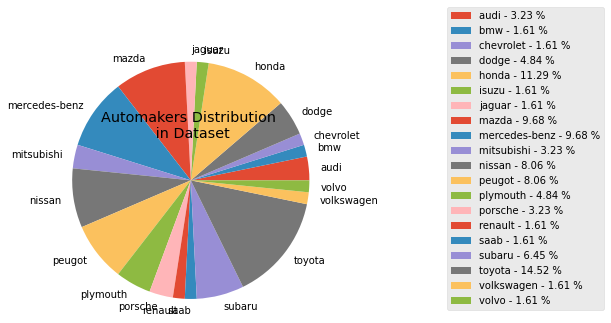

In [ ]:
import matplotlib

fig = plt.figure(4, figsize=(3,3))
ax = fig.add_subplot(211) 
y = grouped_df['count']
color_count = grouped_df.shape[0]
mylabels = grouped_df.index.values.tolist()
porcent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(mylabels, porcent)]

ax.set_title('Automakers Distribution \n in Dataset')
ax.axis("equal")
pie = ax.pie(y,labels = mylabels, startangle=0, radius=4)
ax2 = fig.add_subplot(212)
ax2.axis("off") 
ax2.legend(pie[0], labels, bbox_to_anchor=(2,2), loc="center left")

Unrecognized location 'left center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


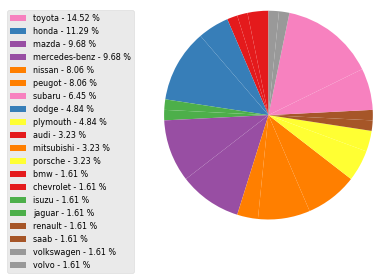

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_count = grouped_df.shape[0]
x = grouped_df.index.values.tolist()
y = grouped_df['count']

colors=cm.Set1(np.arange(color_count)/color_count)
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')

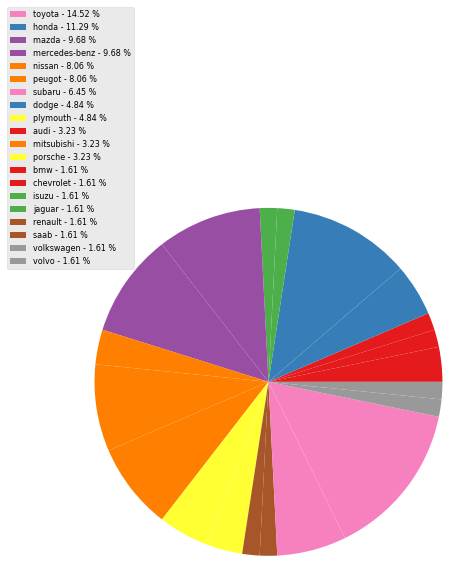

In [ ]:
import matplotlib
from matplotlib import cm

y = grouped_df['count']
color_count = grouped_df.shape[0]
mylabels = grouped_df.index.values.tolist()
porcent = 100.*y/y.sum()

colors=cm.Set1(np.arange(color_count)/color_count)
patches, texts = plt.pie(y, colors=colors, radius=2) #startangle=90, 
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(mylabels, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')


In [ ]:
grouped_df.reset_index(inplace=True)

In [ ]:
grouped_df.columns.tolist()

['make', 'SE Contribution', 'count']

In [ ]:
px.treemap(data_frame=O_Test, path=[px.Constant('Aggregate Distribution of Squared Error by Height_Category & by Makers'), 'height_category','make'], values='SE Contribution', color='SE Contribution')

In [ ]:
px.treemap(data_frame=O_Test, path=[px.Constant('Aggregate Distribution of Squared Error by Makers'), 'height_category'], values='SE Contribution', color='SE Contribution')

In [ ]:
px.treemap(data_frame=O_Test, path=[px.Constant('Aggregate Distribution of Squared Error by Makers'),'make'], values='SE Contribution', color='SE Contribution')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc004e139d0>]],
      dtype=object)

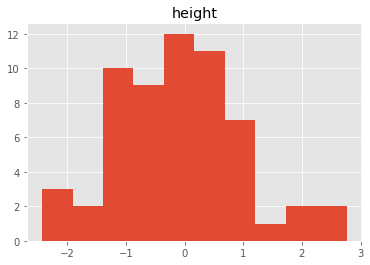

In [ ]:

O_Test.hist(column='height', bins=10)

[Text(0.5, 1.0, 'Error Distribution by Height-bin')]

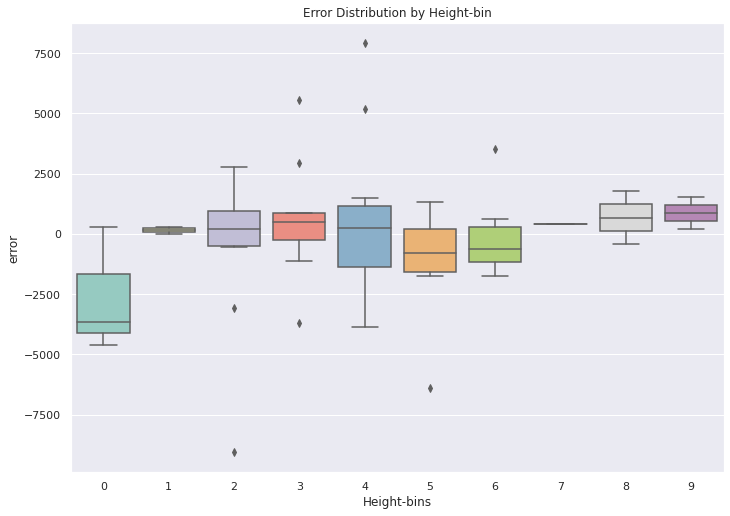

In [ ]:

#fig, ax = plt.subplots(nrows=1, ncols=2)
#ax1 = plt.subplot(1,2,1)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=O_Test, x="Height-bins", y="error", palette="Set3").set(title='Error Distribution by Height-bin') #, kind="box", ax=ax1

#ax2 = plt.subplot(1,2,2)



In [ ]:
height_bins_df=pd.DataFrame(height_bins, columns=['height bins'])
#T_height_bins_df =height_bins_df.T
height_bins_df

,height bins
0,-2.426946
1,-1.908195
2,-1.389445
3,-0.870694
4,-0.351943
5,0.166807
6,0.685558
7,1.204309
8,1.723060
9,2.241810


In [ ]:
height_bins_df['height bins']=height_bins_df['height bins'].round(2)
height_bins_df

,height bins
0,-2.43
1,-1.91
2,-1.39
3,-0.87
4,-0.35
5,0.17
6,0.69
7,1.20
8,1.72
9,2.24


In [ ]:
height_bins_range_df=height_bins_df[:-1]
height_bins_range_df.rename(columns={'height bins':'lower_bound'}, inplace=True)
height_bins_range_df

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lower_bound
0,-2.43
1,-1.91
2,-1.39
3,-0.87
4,-0.35
5,0.17
6,0.69
7,1.20
8,1.72
9,2.24


In [ ]:
height_bins_range_df['upper_bound']=height_bins_df['height bins'][1:].to_frame().reset_index().drop('index', axis=1)
#UB.rename(columns={'height bins':'upper_bound'}, inplace=True)
height_bins_range_df


<ipython-input-158-743f0154d970>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lower_bound,upper_bound
0,-2.43,-1.91
1,-1.91,-1.39
2,-1.39,-0.87
3,-0.87,-0.35
4,-0.35,0.17
5,0.17,0.69
6,0.69,1.20
7,1.20,1.72
8,1.72,2.24
9,2.24,2.76


In [ ]:

last_num = len(height_bins_range_df)+1
height_bins_range_df.insert(loc=0, column='Bin ID', value=np.arange(start=1, stop=last_num))
height_bins_range_df

,Bin ID,lower_bound,upper_bound
0,1,-2.43,-1.91
1,2,-1.91,-1.39
2,3,-1.39,-0.87
3,4,-0.87,-0.35
4,5,-0.35,0.17
5,6,0.17,0.69
6,7,0.69,1.20
7,8,1.20,1.72
8,9,1.72,2.24
9,10,2.24,2.76


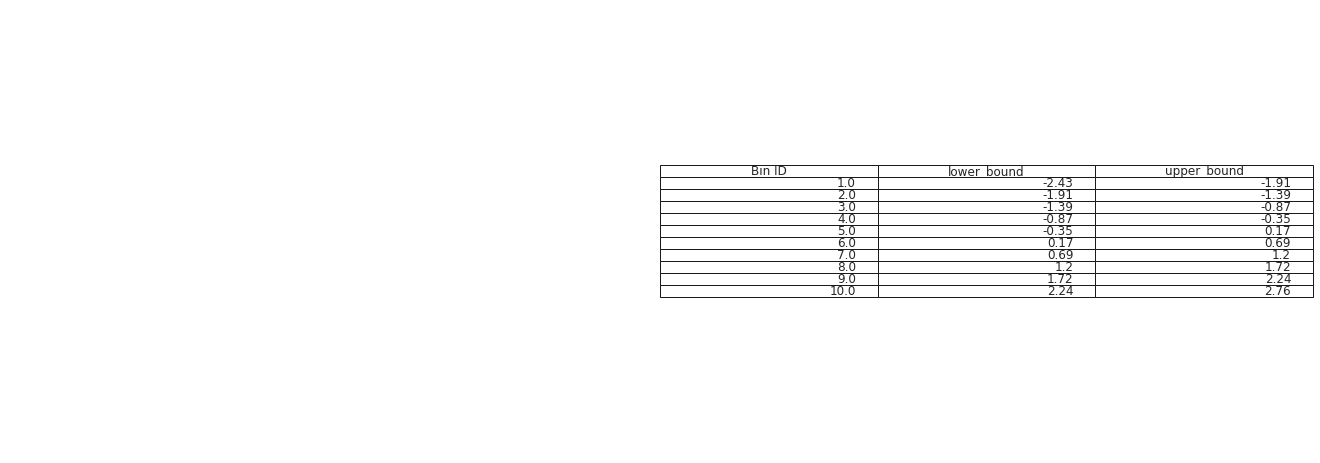

In [ ]:

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


ax.table(cellText=height_bins_range_df.values, colLabels=height_bins_range_df.columns, loc='right')

plt.show()

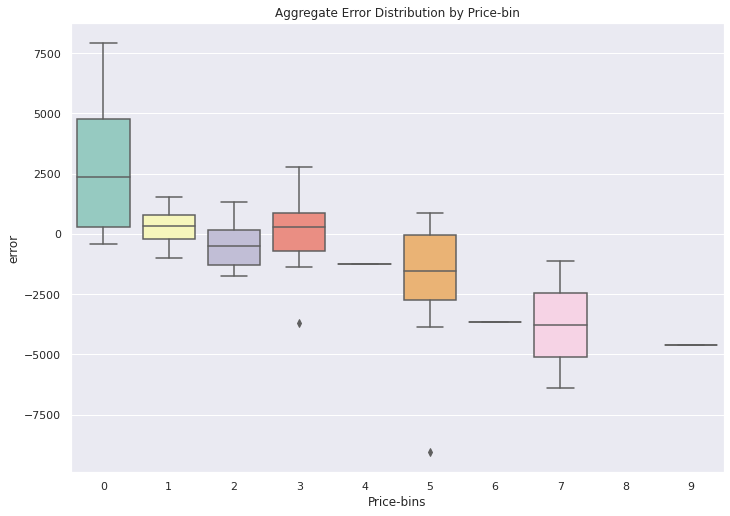

In [ ]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="Price-bins", y="error", data=O_Test, palette="Set3").set(title='Aggregate Error Distribution by Price-bin')

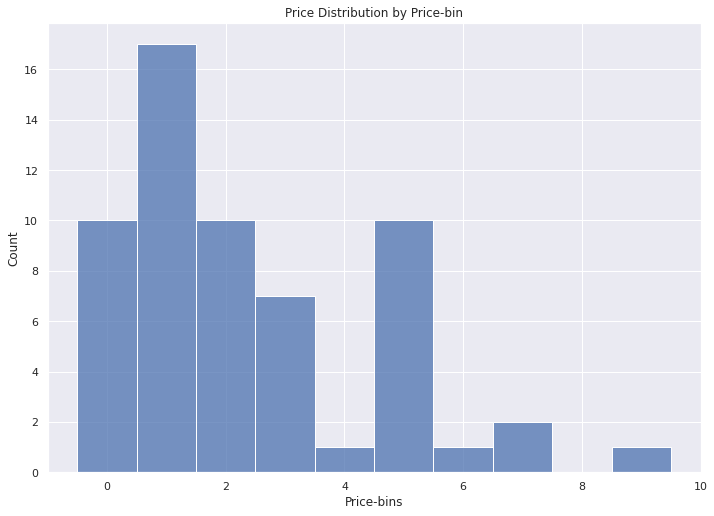

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(data=O_Test, x="Price-bins", palette="Set3").set(title='Price Distribution by Price-bin')

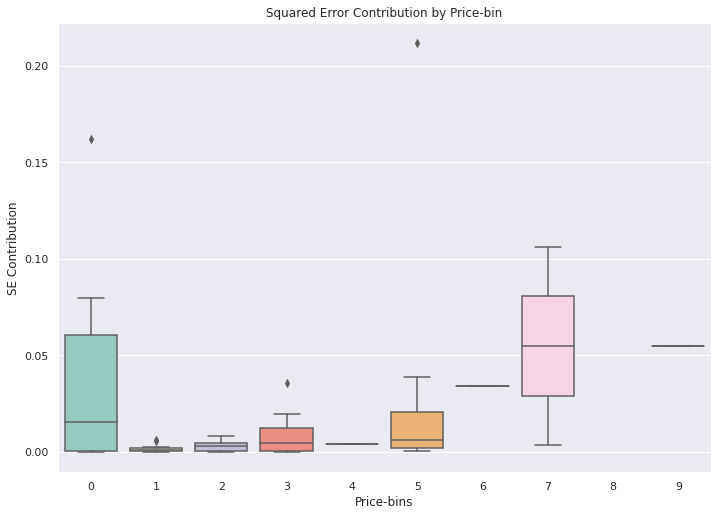

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="Price-bins", y="SE Contribution", data=O_Test, palette="Set3").set(title='Squared Error Contribution by Price-bin')

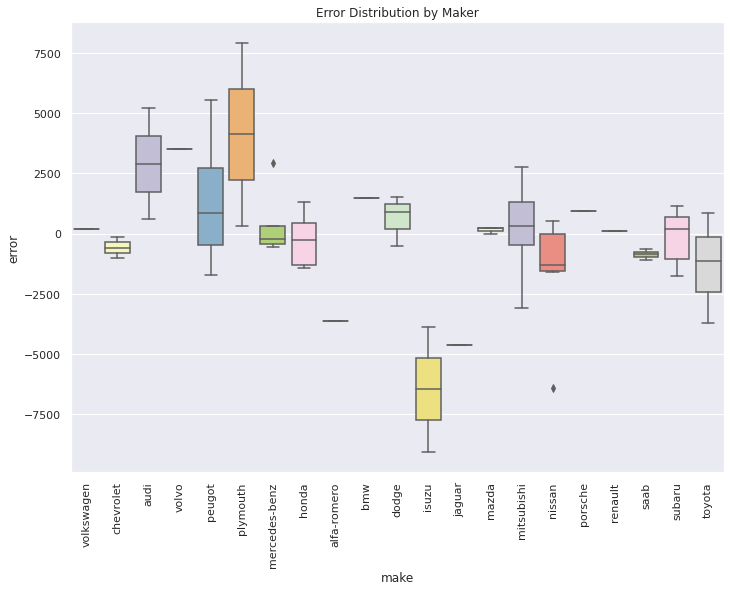

In [ ]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=90)
ax = sns.boxplot(x="make", y="error", data=O_Test, palette="Set3").set(title='Error Distribution by Maker')

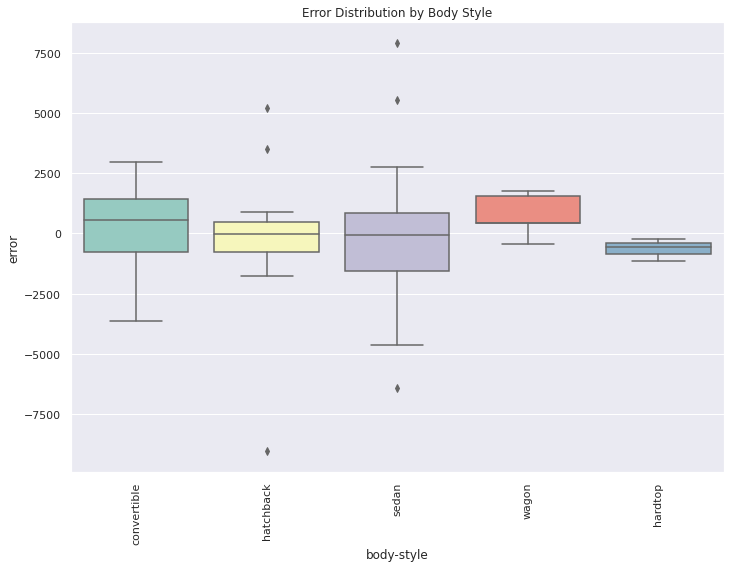

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=90)
ax = sns.boxplot(x="body-style", y="error", data=O_Test, palette="Set3").set(title='Error Distribution by Body Style')

In [ ]:
min_height = O_Test["height"].min()
max_height = O_Test["height"].max()
height_bins = np.linspace(min_height, max_height, 11)
height_labels = list({ i for i in range(0,10)})
O_Test["height-bins"] = pd.cut(O_Test["height"], bins=height_bins, labels=height_labels, include_lowest=True)

In [ ]:
min_height

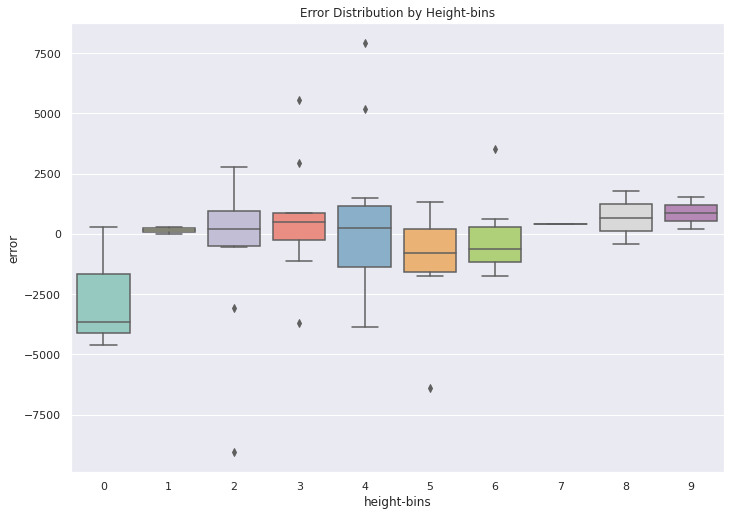

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="height-bins", y="error", data=O_Test, palette="Set3").set(title='Error Distribution by Height-bins')

In [ ]:
O_Test_X.shape

In [ ]:
O_Test.columns.values.tolist()

['make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'Price',
 'Prediction',
 'Price-bins',
 'Height-bins',
 'error',
 'Squared Error',
 'SE Contribution',
 'height_category',
 'height-bins']

In [ ]:
O_Test.to_csv("Post_XGB_DF.csv")

In [ ]:
def bin_by(x, y, nbins=30):
    """
    Bin x by y.
    Returns the binned "x" values and the left edges of the bins
    """
    bins = np.linspace(y.min(), y.max(), nbins+1)
    # To avoid extra bin for the max value
    bins[-1] += 1 

    indicies = np.digitize(y, bins)

    output = []
    for i in xrange(1, len(bins)):
        output.append(x[indicies==i])

    # Just return the left edges of the bins
    bins = bins[:-1]

    return output, bins